# Import Modules

In [1]:
from os import listdir
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from os import listdir
from datetime import datetime
import matplotlib.pyplot as plt
from imutils import paths
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import pandas as pd
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.callbacks import ModelCheckpoint

# Reading Data

In [3]:
classes_dir = sorted(listdir("data/Kather_texture_2016_image_tiles_5000"))
classes_dir.remove('.DS_Store')
classes_dir

['01_TUMOR',
 '02_STROMA',
 '03_COMPLEX',
 '04_LYMPHO',
 '05_DEBRIS',
 '06_MUCOSA',
 '07_ADIPOSE',
 '08_EMPTY']

In [4]:
# for c in classes_dir:
# 	files = listdir(f'data/Kather_texture_2016_image_tiles_5000/{c}')
# 	for f in files:
# 		print(f'{c}: {f}')

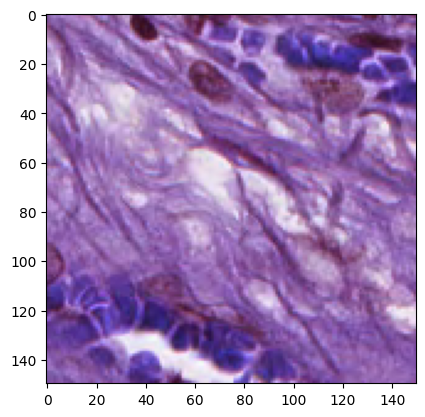

In [5]:
img = cv2.imread('data/Kather_texture_2016_image_tiles_5000/01_TUMOR/89F4_CRC-Prim-HE-09_022.tif_Row_1_Col_1.tif')
plt.imshow(img)

In [6]:
# tf.debugging.set_log_device_placement(True)

when splitting the variable name into '01' and 'tumor', than when doing the hotencoding, the tumor will not be class 0. Because the hotencoding will sort the value alphabetically. Therefore it is easier to pass the variable name as "01_tumor", so will the hot encoding have class 0 as tumor.

In [7]:
with tf.device('/CPU:0'): # running on CPU
	start = datetime.now()
	data = []
	labels_string = []
	path = 'data/Kather_texture_2016_image_tiles_5000'
	for c in classes_dir:
		files = listdir(f'{path}/{c}')
		for f in files:
			# l = c.split('_')[1].lower() # to pass only name of class without numbering.
			labels_string.append(c)
			img = load_img(f'{path}/{c}/{f}', target_size=(128, 128))
			img = img_to_array(img)
			# img = preprocess_input(img)
			img = tf.cast(img, tf.float32) / 255.0
			data.append(img)
	end = datetime.now()

	data = np.array(data, dtype='float32')
	labels_string = np.array(labels_string)
	print(end-start)


Metal device set to: Apple M1 Max


2023-03-23 16:13:47.076160: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-23 16:13:47.076285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


0:00:02.503091


In [8]:
data[3][0][0]

array([0.36862746, 0.14509805, 0.3529412 ], dtype=float32)

In [9]:
labels_string

array(['01_TUMOR', '01_TUMOR', '01_TUMOR', ..., '08_EMPTY', '08_EMPTY',
       '08_EMPTY'], dtype='<U10')

In [10]:
data.shape

(5000, 128, 128, 3)

In [11]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels_string)
# labels = to_categorical(labels)
print(labels[0], labels[0][0], type(labels[0]))

[1 0 0 0 0 0 0 0] 1 <class 'numpy.ndarray'>


Checking for classes

In [12]:
lb.classes_

array(['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS',
       '06_MUCOSA', '07_ADIPOSE', '08_EMPTY'], dtype='<U10')

## Train-split data

In [13]:
# Split into train, val, test set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,train_size=0.8, random_state=13)
# x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25,train_size =0.75)

In [14]:
len(y_test)

1000

In [15]:
print(lb.inverse_transform( y_test[0:5] ))
print('--------')
print(y_test)

['03_COMPLEX' '02_STROMA' '03_COMPLEX' '04_LYMPHO' '03_COMPLEX']
--------
[[0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


In [16]:
print(lb.inverse_transform(y_test))

['03_COMPLEX' '02_STROMA' '03_COMPLEX' '04_LYMPHO' '03_COMPLEX' '08_EMPTY'
 '08_EMPTY' '05_DEBRIS' '05_DEBRIS' '08_EMPTY' '05_DEBRIS' '02_STROMA'
 '06_MUCOSA' '06_MUCOSA' '05_DEBRIS' '07_ADIPOSE' '08_EMPTY' '07_ADIPOSE'
 '04_LYMPHO' '08_EMPTY' '03_COMPLEX' '03_COMPLEX' '04_LYMPHO' '05_DEBRIS'
 '04_LYMPHO' '02_STROMA' '01_TUMOR' '03_COMPLEX' '03_COMPLEX' '05_DEBRIS'
 '05_DEBRIS' '07_ADIPOSE' '07_ADIPOSE' '02_STROMA' '04_LYMPHO' '06_MUCOSA'
 '06_MUCOSA' '03_COMPLEX' '03_COMPLEX' '03_COMPLEX' '03_COMPLEX'
 '06_MUCOSA' '08_EMPTY' '02_STROMA' '06_MUCOSA' '01_TUMOR' '06_MUCOSA'
 '07_ADIPOSE' '07_ADIPOSE' '02_STROMA' '08_EMPTY' '07_ADIPOSE'
 '03_COMPLEX' '07_ADIPOSE' '02_STROMA' '07_ADIPOSE' '04_LYMPHO'
 '06_MUCOSA' '01_TUMOR' '04_LYMPHO' '07_ADIPOSE' '07_ADIPOSE' '05_DEBRIS'
 '06_MUCOSA' '04_LYMPHO' '04_LYMPHO' '08_EMPTY' '08_EMPTY' '02_STROMA'
 '06_MUCOSA' '05_DEBRIS' '07_ADIPOSE' '05_DEBRIS' '05_DEBRIS' '01_TUMOR'
 '05_DEBRIS' '02_STROMA' '03_COMPLEX' '02_STROMA' '02_STROMA' '06_MUCOSA'
 '

In [17]:
print(lb.fit_transform((0, 0, 1, 0, 0, 0, 0, 0)))

[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


## Data augmentation

In [18]:
def plotImages(images_arr):
    fig, axes = plt.subplots(3, 5, figsize=(15,7))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        # ax.imshow((img * 255).astype(np.uint8))

    plt.tight_layout()
    plt.show()

In [19]:
image_gen = ImageDataGenerator(#rescale=1/255,
							   horizontal_flip=True,
							   rotation_range=45,
							   zoom_range = 0.5,
							   width_shift_range=0.2,
							   height_shift_range=0.2,
							   shear_range=0.2,
							   fill_mode='nearest')
#
# train_data_gen = image_gen.flow_from_directory(batch_size=128,
#                                                directory=base_dir,
#                                                shuffle=True,
#                                                target_size=(150,150))
train_data_gen = image_gen.flow(x_train, y_train,
									batch_size=32, #128
								   # directory=base_dir,
								   shuffle=False,
								   )

test_data_gen = image_gen.flow(x_test, y_test,
									batch_size=32,
								   # directory=base_dir,
								   shuffle=False,
								   )

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(15)]
plotImages(augmented_images)

## Model

In [22]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(8, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)       

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
EPOCHS = 150

In [26]:
filepath = 'model_gcm2.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [27]:
history = model.fit(train_data_gen, batch_size = 32, epochs=EPOCHS, validation_data=test_data_gen,  callbacks=[checkpoint])

Epoch 1/150


2023-03-23 16:14:17.423989: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-23 16:14:17.765938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - ETA: 0s - loss: 1.3045 - accuracy: 0.4113

2023-03-23 16:14:24.859559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.58900, saving model to model_gcm2.h5
125/125 [==============================] - 9s 70ms/step - loss: 1.3045 - accuracy: 0.4113 - val_loss: 0.9085 - val_accuracy: 0.5890
Epoch 2/150
125/125 [==============================] - ETA: 0s - loss: 0.8849 - accuracy: 0.6185
Epoch 2: val_accuracy improved from 0.58900 to 0.65000, saving model to model_gcm2.h5
125/125 [==============================] - 8s 68ms/step - loss: 0.8849 - accuracy: 0.6185 - val_loss: 0.8332 - val_accuracy: 0.6500
Epoch 3/150
125/125 [==============================] - ETA: 0s - loss: 0.7735 - accuracy: 0.6880
Epoch 3: val_accuracy improved from 0.65000 to 0.66600, saving model to model_gcm2.h5
125/125 [==============================] - 9s 68ms/step - loss: 0.7735 - accuracy: 0.6880 - val_loss: 0.8086 - val_accuracy: 0.6660
Epoch 4/150
125/125 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.6893
Epoch 4: val_accuracy improved from 0.66600 to 0.75900, s

In [248]:
#history = model.fit(datagen.flow(x_train, y_train), batch_size = 32, epochs=EPOCHS, validation_data=datagen.flow(x_test, y_test))

Epoch 1/25
125/125 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.8343

2023-03-23 13:04:29.448812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 8s 66ms/step - loss: 0.4467 - accuracy: 0.8343 - val_loss: 0.4024 - val_accuracy: 0.8390
Epoch 2/25
125/125 [==============================] - 8s 63ms/step - loss: 0.3901 - accuracy: 0.8600 - val_loss: 0.4163 - val_accuracy: 0.8440
Epoch 3/25
125/125 [==============================] - 8s 63ms/step - loss: 0.3574 - accuracy: 0.8745 - val_loss: 0.3725 - val_accuracy: 0.8590
Epoch 4/25
125/125 [==============================] - 8s 63ms/step - loss: 0.3592 - accuracy: 0.8715 - val_loss: 0.3772 - val_accuracy: 0.8490
Epoch 5/25
125/125 [==============================] - 8s 63ms/step - loss: 0.3299 - accuracy: 0.8838 - val_loss: 0.4091 - val_accuracy: 0.8590
Epoch 6/25
125/125 [==============================] - 8s 64ms/step - loss: 0.3199 - accuracy: 0.8888 - val_loss: 0.3994 - val_accuracy: 0.8540
Epoch 7/25
125/125 [==============================] - 8s 63ms/step - loss: 0.3125 - accuracy: 0.8898 - val_loss: 0.4065 - val_accuracy: 0.8530
Epoch 8/25

In [229]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 10ms/step - loss: 1.1710 - accuracy: 0.8210


In [624]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

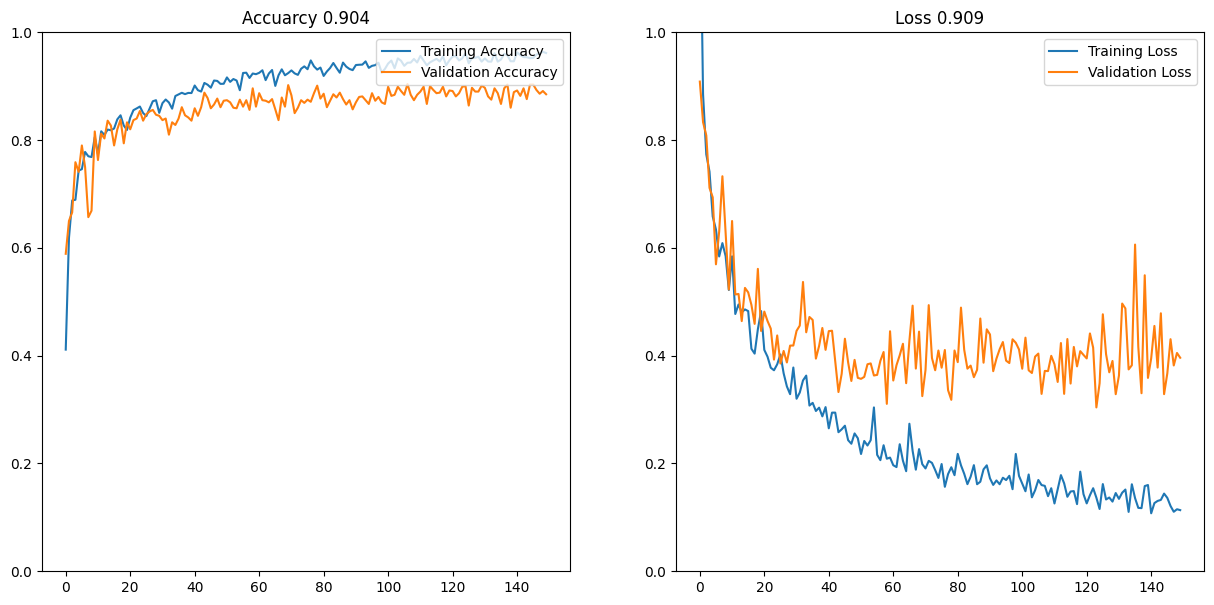

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_title(f'Accuarcy {round(max(val_acc),3)}')
ax1.legend(loc='upper right')
ax1.set_ylim((0,1))

ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_title(f'Loss {round(max(val_loss),3)}')
ax2.legend(loc='upper right')
ax2.set_ylim((0,1))
plt.show()

In [255]:

print(datagen.flow(x_train))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


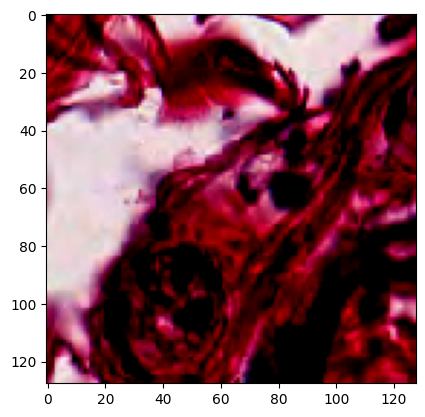

In [263]:
plt.imshow(x_train[0]*255)

[[[[-0.01176471 -0.62352943 -0.372549  ]
   [ 0.0196079  -0.5921569  -0.34117645]
   [ 0.20000005 -0.5686275  -0.3098039 ]
   ...
   [ 0.16078436 -0.5764706  -0.372549  ]
   [ 0.10588241 -0.5764706  -0.42745095]
   [ 0.09019613 -0.5921569  -0.44313723]]

  [[-0.0745098  -0.6627451  -0.42745095]
   [-0.02745098 -0.6156863  -0.38039213]
   [ 0.18431377 -0.58431375 -0.34117645]
   ...
   [ 0.11372554 -0.56078434 -0.3960784 ]
   [ 0.06666672 -0.5372549  -0.3960784 ]
   [-0.00392157 -0.60784316 -0.46666664]]

  [[-0.09803921 -0.6862745  -0.45098037]
   [-0.03529412 -0.62352943 -0.38823527]
   [ 0.18431377 -0.5764706  -0.35686272]
   ...
   [ 0.04313731 -0.56078434 -0.41960782]
   [ 0.01176476 -0.5137255  -0.38039213]
   [-0.09019607 -0.6156863  -0.4823529 ]]

  ...

  [[ 0.28627455 -0.29411763 -0.08235294]
   [ 0.5764706  -0.00392157  0.20784318]
   [ 0.70980394  0.3803922   0.4901961 ]
   ...
   [ 0.27843142 -0.47450978 -0.17647058]
   [ 0.13725495 -0.52156866 -0.23921567]
   [ 0.16078436 

TypeError: Invalid shape (4000, 128, 128, 3) for image data

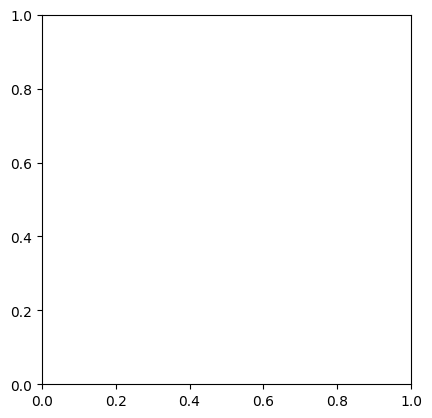

In [292]:
datagen = ImageDataGenerator(rotation_range=30, fill_mode='nearest')

one = x_train*255
print(one)
print(one.shape)
plt.imshow(one)
# iterator
aug_iter = datagen.flow(one, batch_size=3)
print(aug_iter)
# plt.imshow(aug_iter)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
ax.imshow(aug_iter)
#
# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')

	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

In [307]:
base_dir = os.path.dirname('/Users/gcm/PyProjects/computer_vision/data/Kather_texture_2016_image_tiles_5000/')
print(base_dir)

train_dir = os.path.join(base_dir, '01_TUMOR/')
print(train_dir)

/Users/gcm/PyProjects/computer_vision/data/Kather_texture_2016_image_tiles_5000
/Users/gcm/PyProjects/computer_vision/data/Kather_texture_2016_image_tiles_5000/01_TUMOR/


In [609]:
x_train[0]

array([[[0.49411765, 0.1882353 , 0.3137255 ],
        [0.50980395, 0.20392157, 0.32941177],
        [0.6       , 0.21568628, 0.34509805],
        ...,
        [0.5803922 , 0.21176471, 0.3137255 ],
        [0.5529412 , 0.21176471, 0.28627452],
        [0.54509807, 0.20392157, 0.2784314 ]],

       [[0.4627451 , 0.16862746, 0.28627452],
        [0.4862745 , 0.19215687, 0.30980393],
        [0.5921569 , 0.20784314, 0.32941177],
        ...,
        [0.5568628 , 0.21960784, 0.3019608 ],
        [0.53333336, 0.23137255, 0.3019608 ],
        [0.49803922, 0.19607843, 0.26666668]],

       [[0.4509804 , 0.15686275, 0.27450982],
        [0.48235294, 0.1882353 , 0.30588236],
        [0.5921569 , 0.21176471, 0.32156864],
        ...,
        [0.52156866, 0.21960784, 0.2901961 ],
        [0.5058824 , 0.24313726, 0.30980393],
        [0.45490196, 0.19215687, 0.25882354]],

       ...,

       [[0.6431373 , 0.3529412 , 0.45882353],
        [0.7882353 , 0.49803922, 0.6039216 ],
        [0.85490197, 0

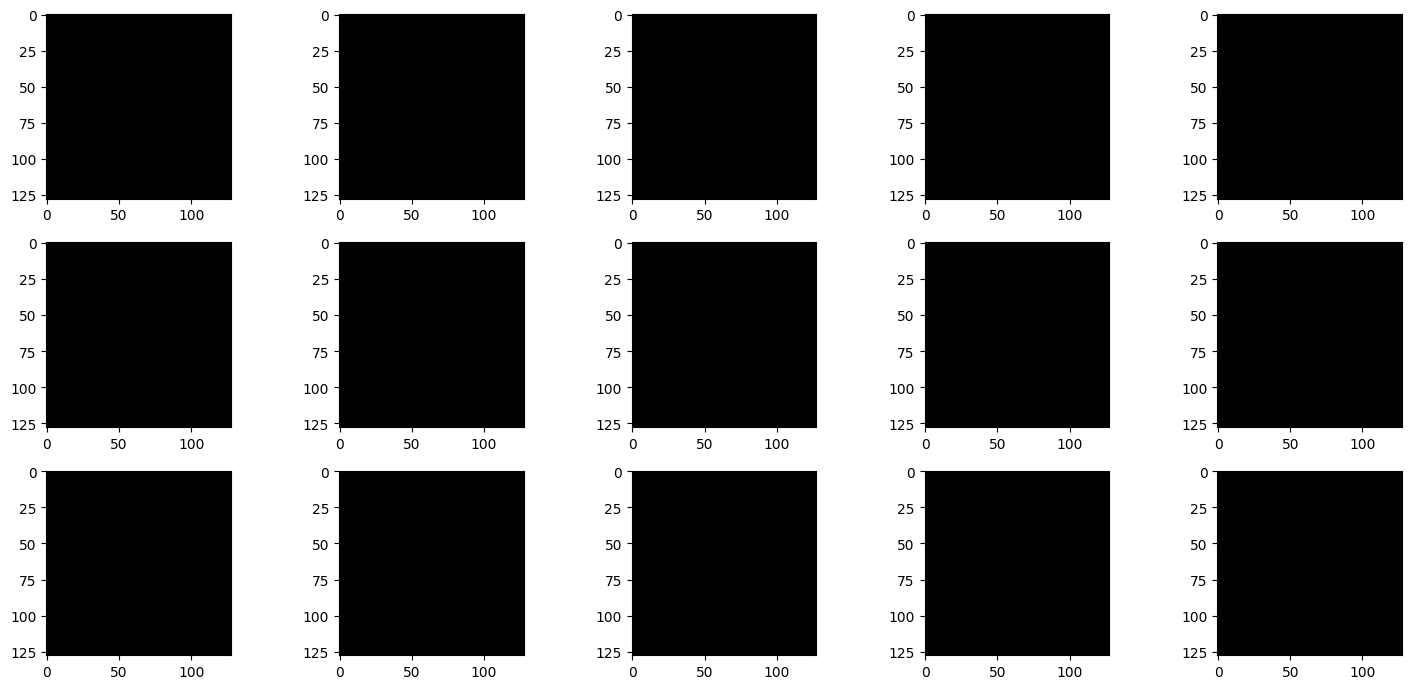

In [607]:
train_data_gen

In [ ]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    # steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)